Source frame Mass of Neutron Star = $1.35 M_{\odot}$ is known. Redshift = Detector Frame Chirp Mass/Source Frame Chirp Mass -1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import h5py

import matplotlib.pylab as plt
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
import astropy.cosmology as cosmo
import astropy.units as u
import pymc as pm
import scipy.integrate as si
import seaborn as sns
import xarray as xr

sns.set_context('notebook')

In [3]:
NEVENTS = 10**4

Data Loading

In [19]:
file=h5py.File('Sam.h5','r')
z_med=np.zeros(NEVENTS)
deff_med=np.zeros(NEVENTS)
sigma_z=np.zeros(NEVENTS)
sigma_deff=np.zeros(NEVENTS)

Gpc = 10**3
#3.0857E+25

for i in range(NEVENTS):
    z_med[i]=np.array(file['z_med'+str(i)])
    deff_med[i]=np.array(file['deff_med'+str(i)])/Gpc
    sigma_z[i]=np.array(file['z_sd'+str(i)])
    sigma_deff[i]=np.array(file['deff_sd'+str(i)])/Gpc

No Noise Injection

Text(0, 0.5, '(deff_obs-deff_model)/sigma_deff_obs')

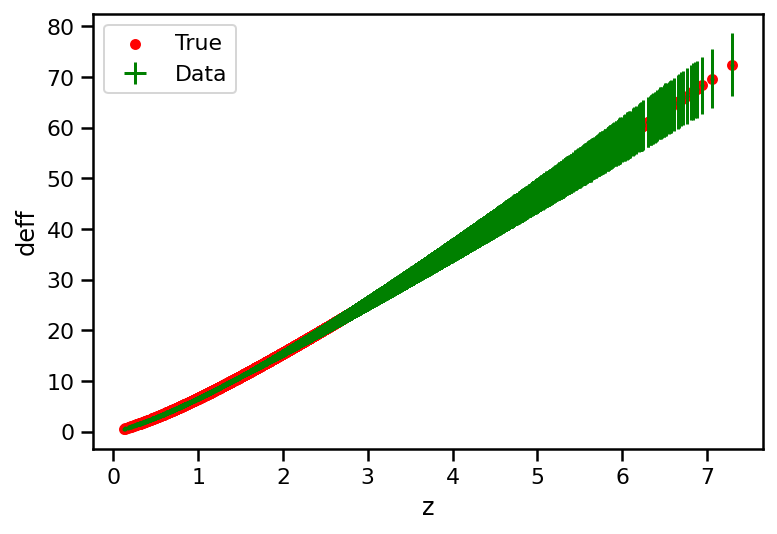

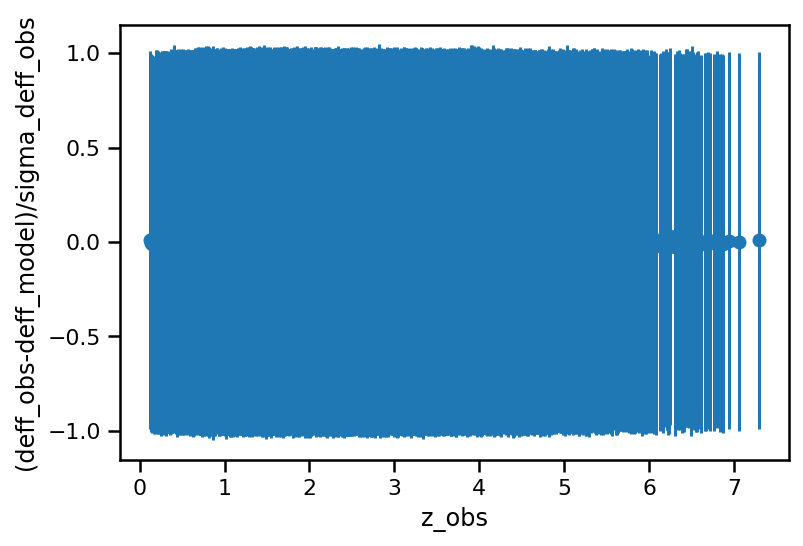

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_yscale('log')
ax.errorbar(z_med,deff_med,xerr=sigma_z,yerr=sigma_deff, markersize=1, color = 'green', fmt = 'o', label='Data')
ax.scatter(z_med, cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc), s=20, color = 'red', label='True')
plt.xlabel('z')
plt.ylabel('deff')
plt.legend()

plt.figure()
plt.errorbar(z_med, (deff_med-cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc).value)/sigma_deff, yerr=np.ones(NEVENTS), fmt='o')
plt.xlabel('z_obs')
plt.ylabel('(deff_obs-deff_model)/sigma_deff_obs')

z error is negligible. $\frac{\Delta D_{eff}}{D_{eff}}$ is within $1-\sigma$. So works fine.

Pymc does not have interpolation module, so it is written.

In [21]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [22]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

In [23]:
def make_model(zs_obs, sigma_zs_obs, dls_obs, sigma_dls_obs, zmax=100):
    zinterp = plt.expm1(plt.linspace(plt.log(1), plt.log(1+zmax), 1024))

    with pm.Model() as model:
        h = pm.Uniform('h', 0.5, 2, initval=1)
        Om = pm.Uniform('Om', 0, 1, initval=0.3)
        w = pm.Uniform('w', -1.5, -0.5, initval=-1)
        wDM = pm.Uniform('wDM', -0.5, 0.5, initval=0)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc

        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)

        #z = pm.Uniform('z', 0, zmax, initval=abs(zs_obs), shape=zs_obs.shape[0])
        dL = pm.Deterministic('dL', at_interp(zs_obs, zinterp, dLinterp))

        #pm.Normal('z_likelihood', mu=z, sigma=sigma_zs_obs, observed=zs_obs)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_dls_obs, observed=dls_obs)
    return model

In [24]:
with make_model(z_med, sigma_z, deff_med, sigma_deff) as model:
    trace = pm.sample(chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [h, Om, w, wDM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 351 seconds.
The acceptance probability does not match the target. It is 0.8811, but should be close to 0.8. Try to increase the number of tuning steps.


In [25]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w', 'wDM']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.700,0.002,0.697,0.703,0.000,0.000,738.0,989.0,1.00
Om,0.301,0.020,0.261,0.339,0.001,0.001,757.0,774.0,1.01
w,-1.003,0.043,-1.089,-0.924,0.002,0.001,702.0,767.0,1.01
wDM,-0.000,0.017,-0.031,0.035,0.001,0.000,762.0,771.0,1.01


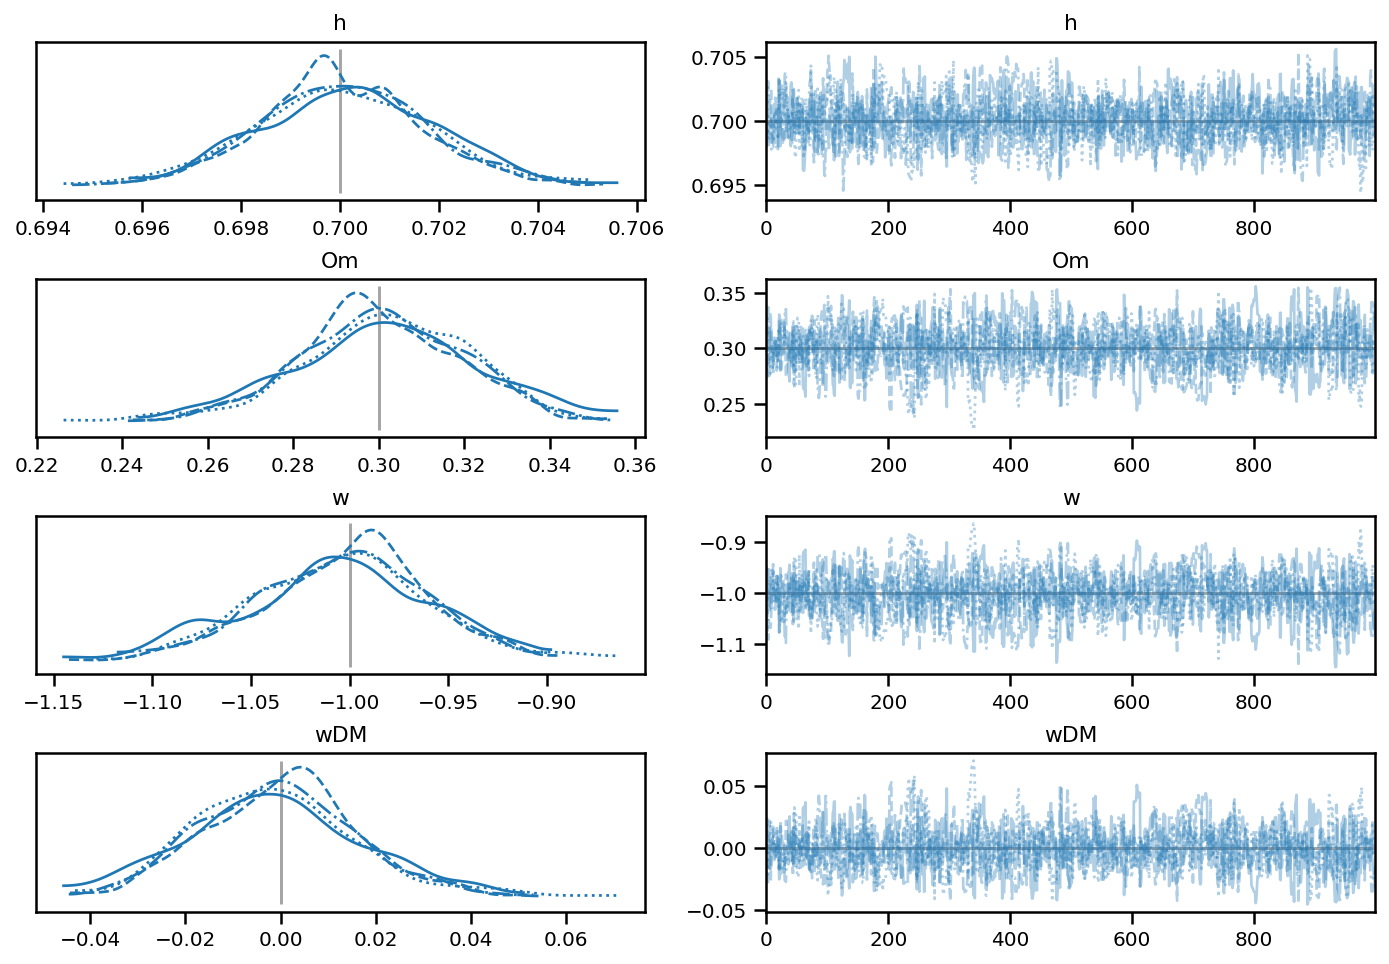

In [26]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'w', 'wDM'],
                  lines=[('h', {}, 0.7),
                        ('Om', {}, 0.3),
                        ('w', {}, -1),
                        ('wDM', {}, 0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

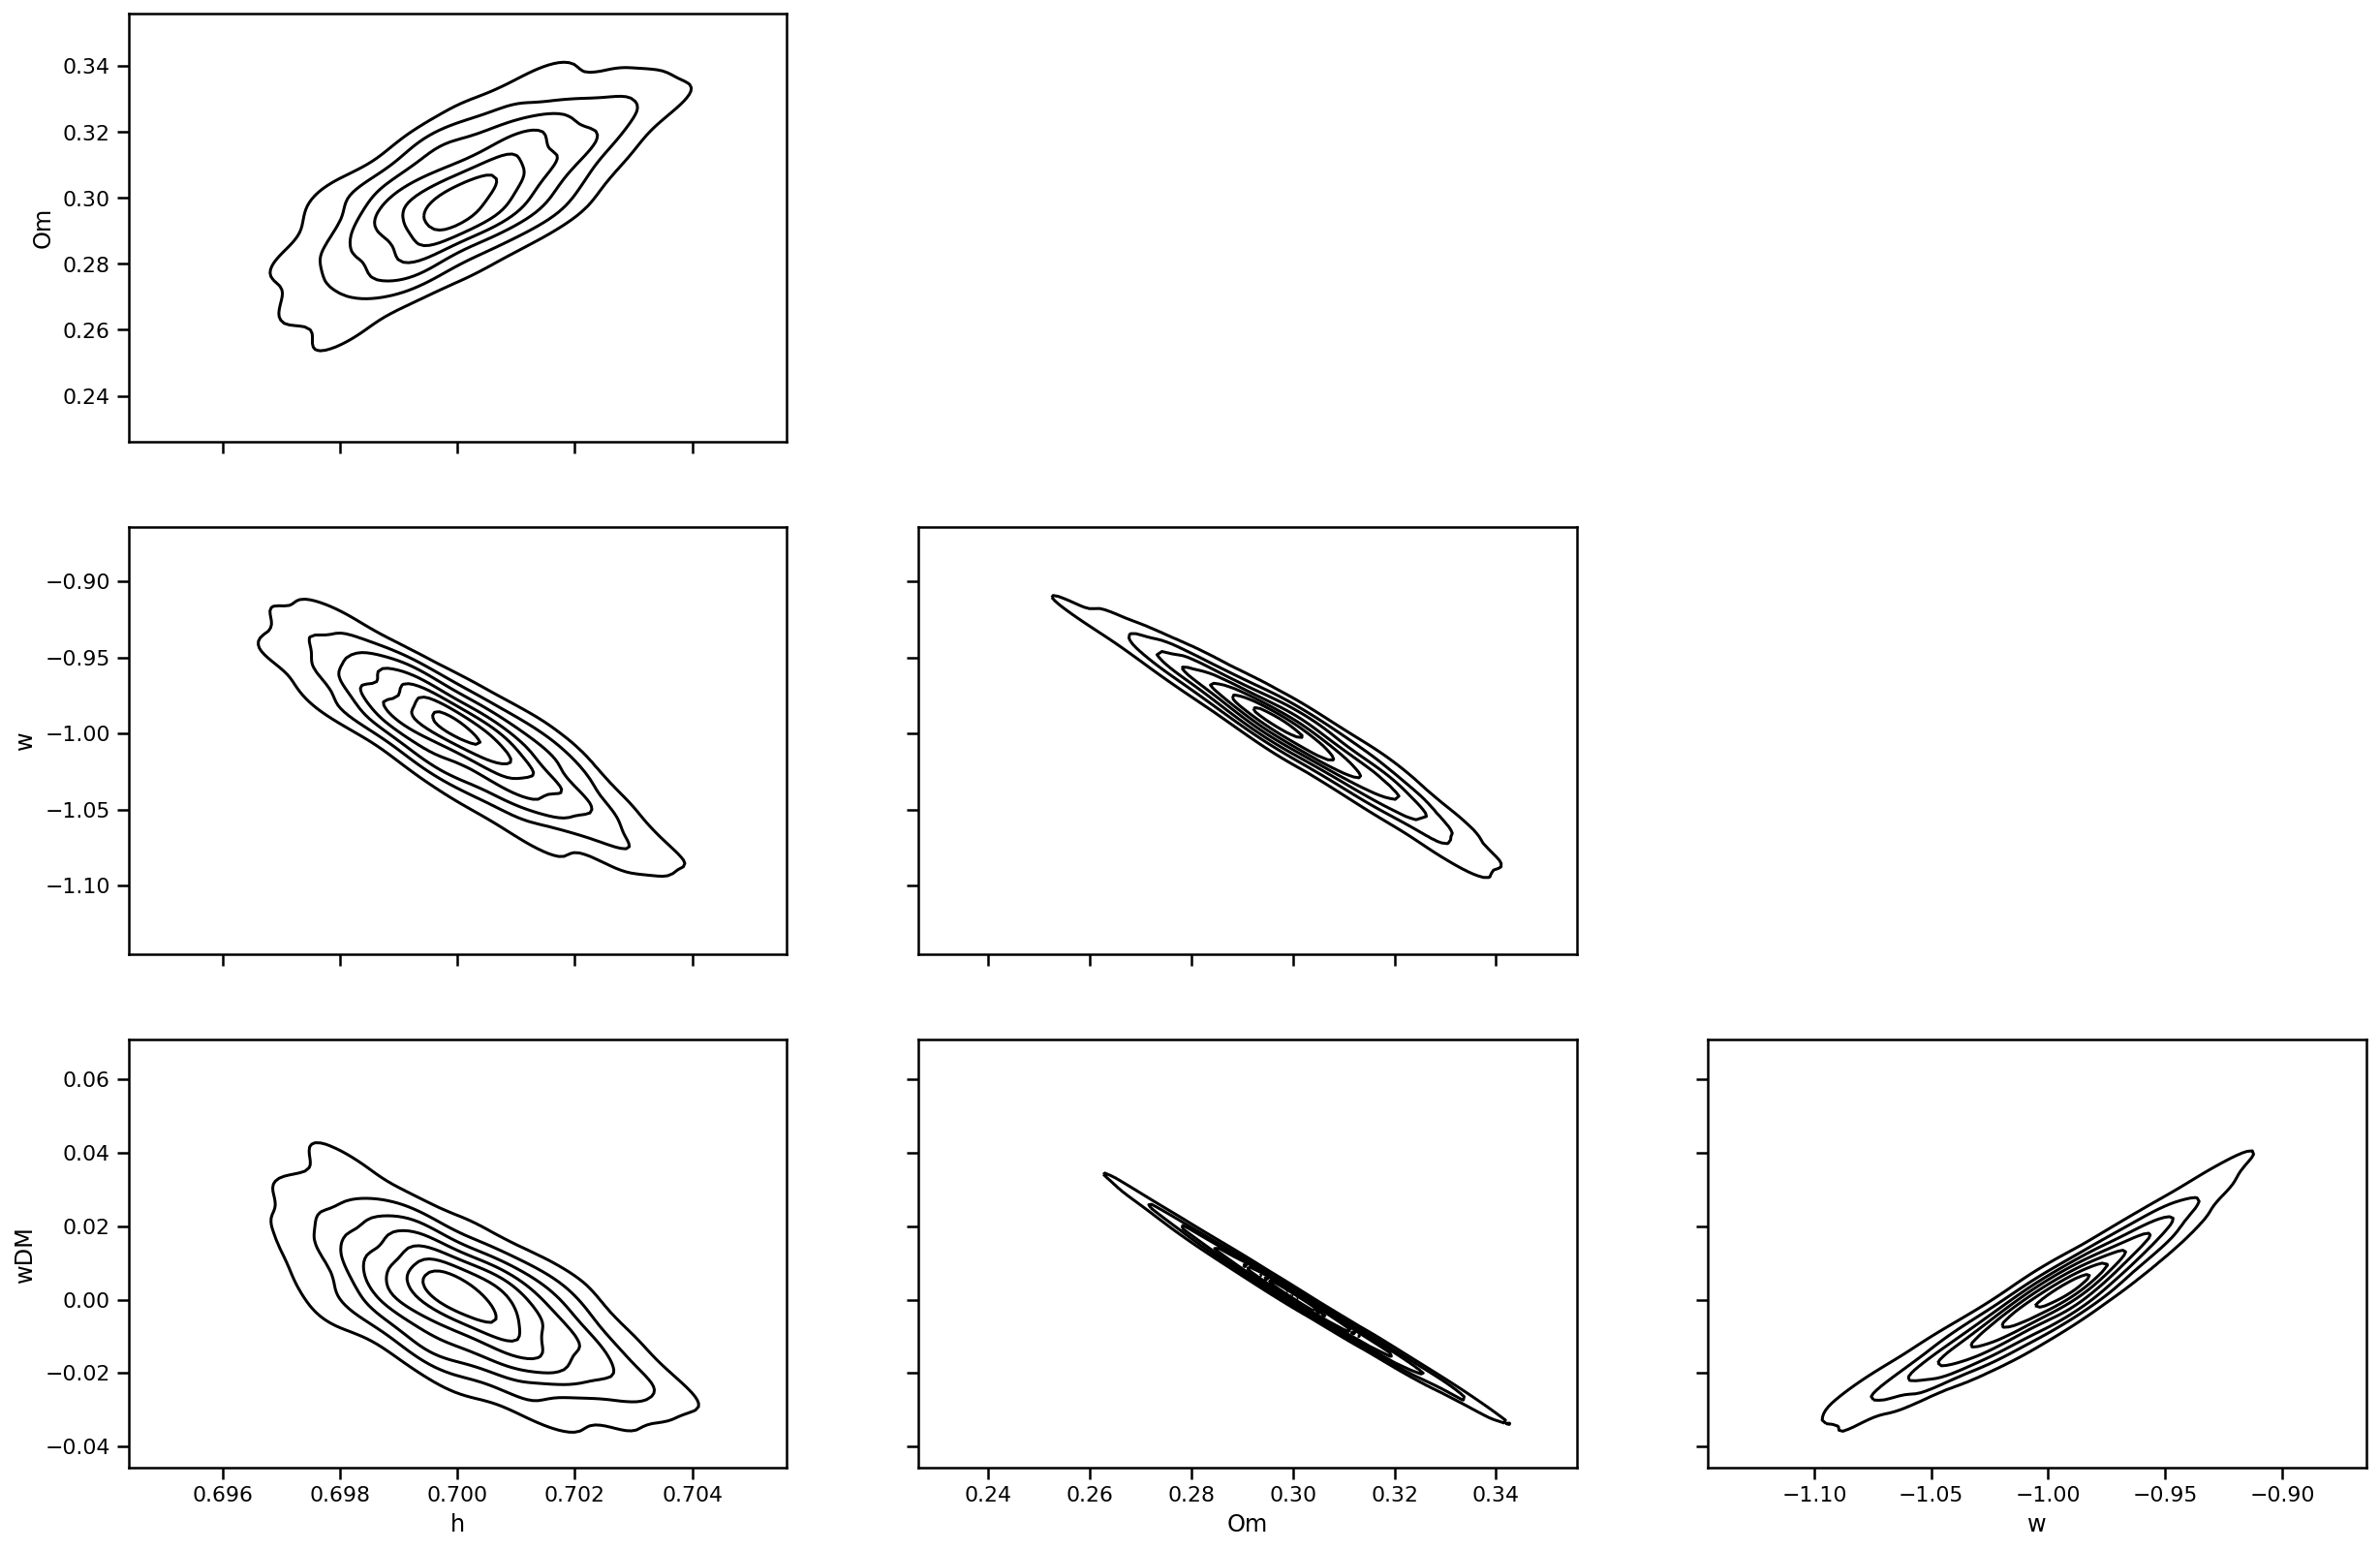

In [27]:
axes = az.plot_pair(trace, var_names=['h', 'Om', 'w', 'wDM'], kind=['kde'], divergences=True)

No noise injection works fine. True value lies within $1-\sigma$ of central tendency measure.

With Noise Injection:

In [28]:
deff_med = deff_med + sigma_deff*np.random.randn(NEVENTS)

Text(0, 0.5, '(deff_obs-deff_model)/sigma_deff_obs')

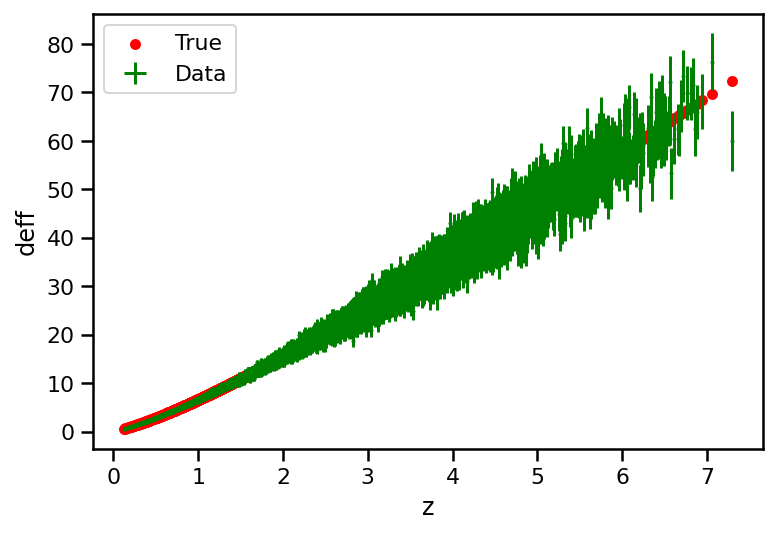

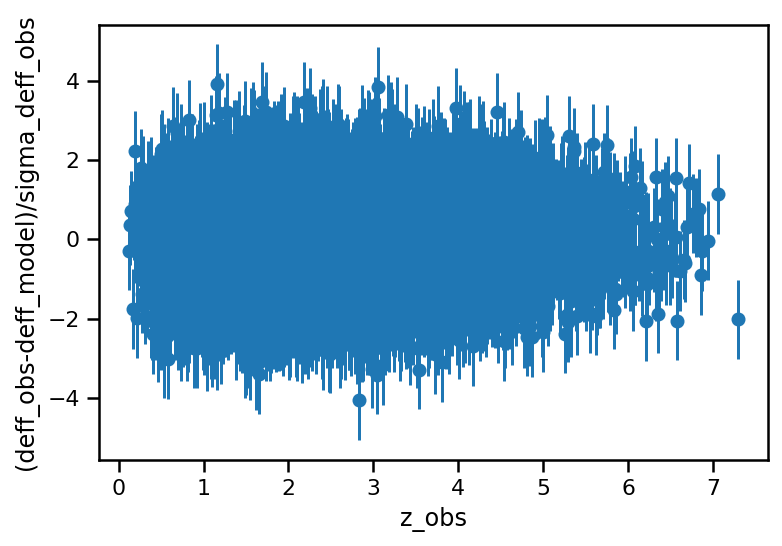

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.set_yscale('log')
ax.errorbar(z_med,deff_med,xerr=sigma_z,yerr=sigma_deff, markersize=1, color = 'green', fmt = 'o', label='Data')
ax.scatter(z_med, cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc), s=20, color = 'red', label='True')
plt.xlabel('z')
plt.ylabel('deff')
plt.legend()

plt.figure()
plt.errorbar(z_med, (deff_med-cosmo.FlatLambdaCDM(70, 0.3).luminosity_distance(z_med).to(u.Gpc).value)/sigma_deff, yerr=np.ones(NEVENTS), fmt='o')
plt.xlabel('z_obs')
plt.ylabel('(deff_obs-deff_model)/sigma_deff_obs')

z error is again negligible. $\Delta d_{eff}/d_{eff}$ is within $4-\sigma$ with mean 0. Let's proceed.

Cosmological Parameter Estimation by Pymc

In [30]:
with make_model(z_med, sigma_z, deff_med, sigma_deff) as model:
    trace = pm.sample(chains=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [h, Om, w, wDM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 330 seconds.


In [31]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w', 'wDM']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.699,0.002,0.696,0.703,0.000,0.000,828.0,1037.0,1.01
Om,0.324,0.020,0.287,0.363,0.001,0.001,730.0,848.0,1.01
w,-1.034,0.046,-1.125,-0.951,0.002,0.001,707.0,798.0,1.01
wDM,-0.019,0.016,-0.051,0.009,0.001,0.000,735.0,847.0,1.01


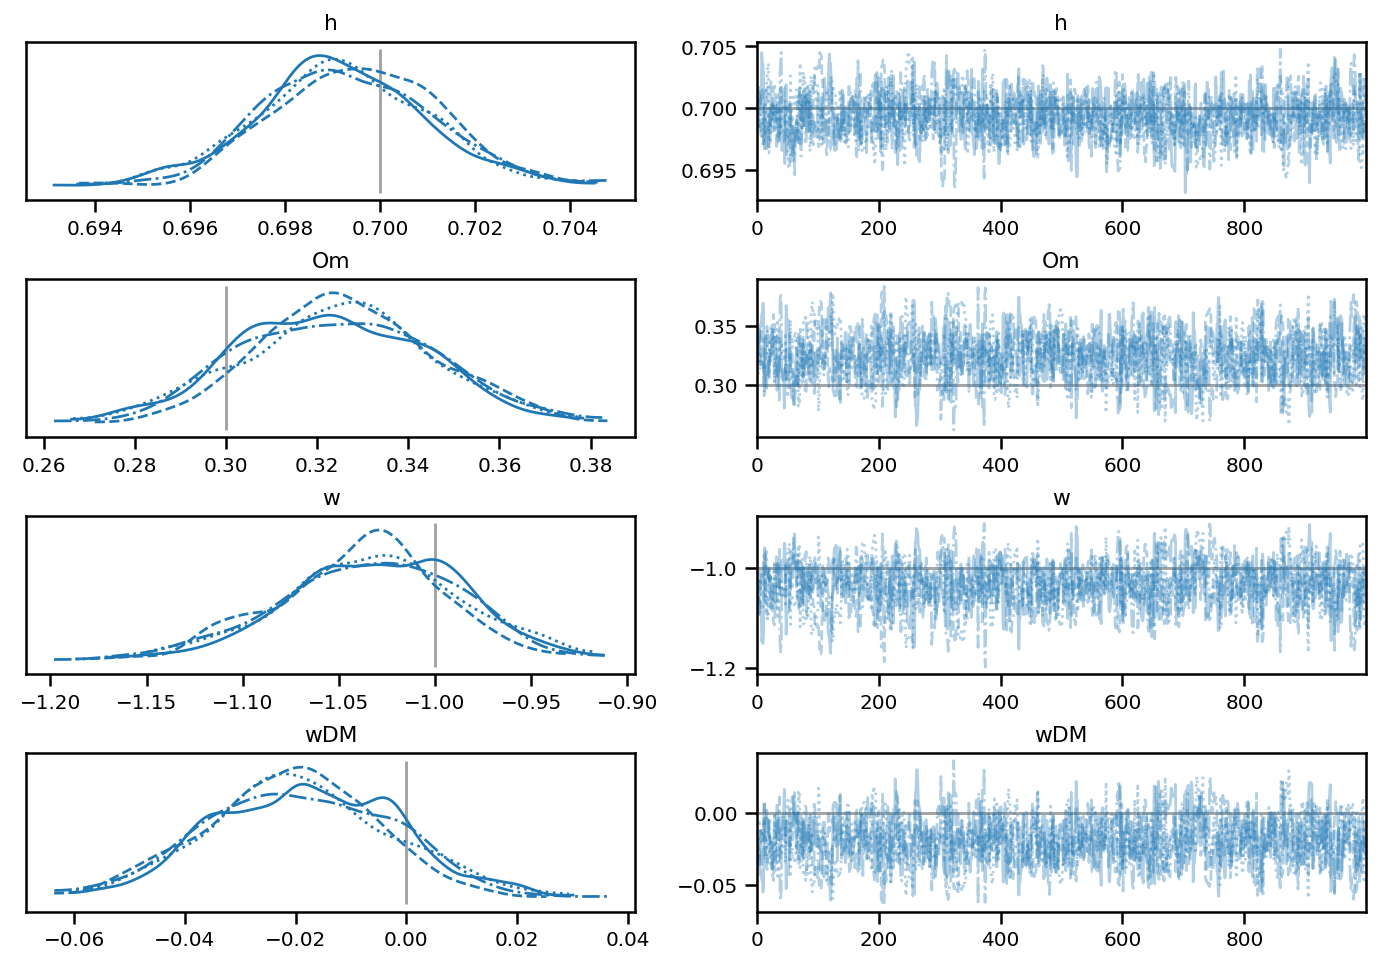

In [32]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'w', 'wDM'],
                  lines=[('h', {}, 0.7),
                        ('Om', {}, 0.3),
                        ('w', {}, -1),
                        ('wDM', {}, 0)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

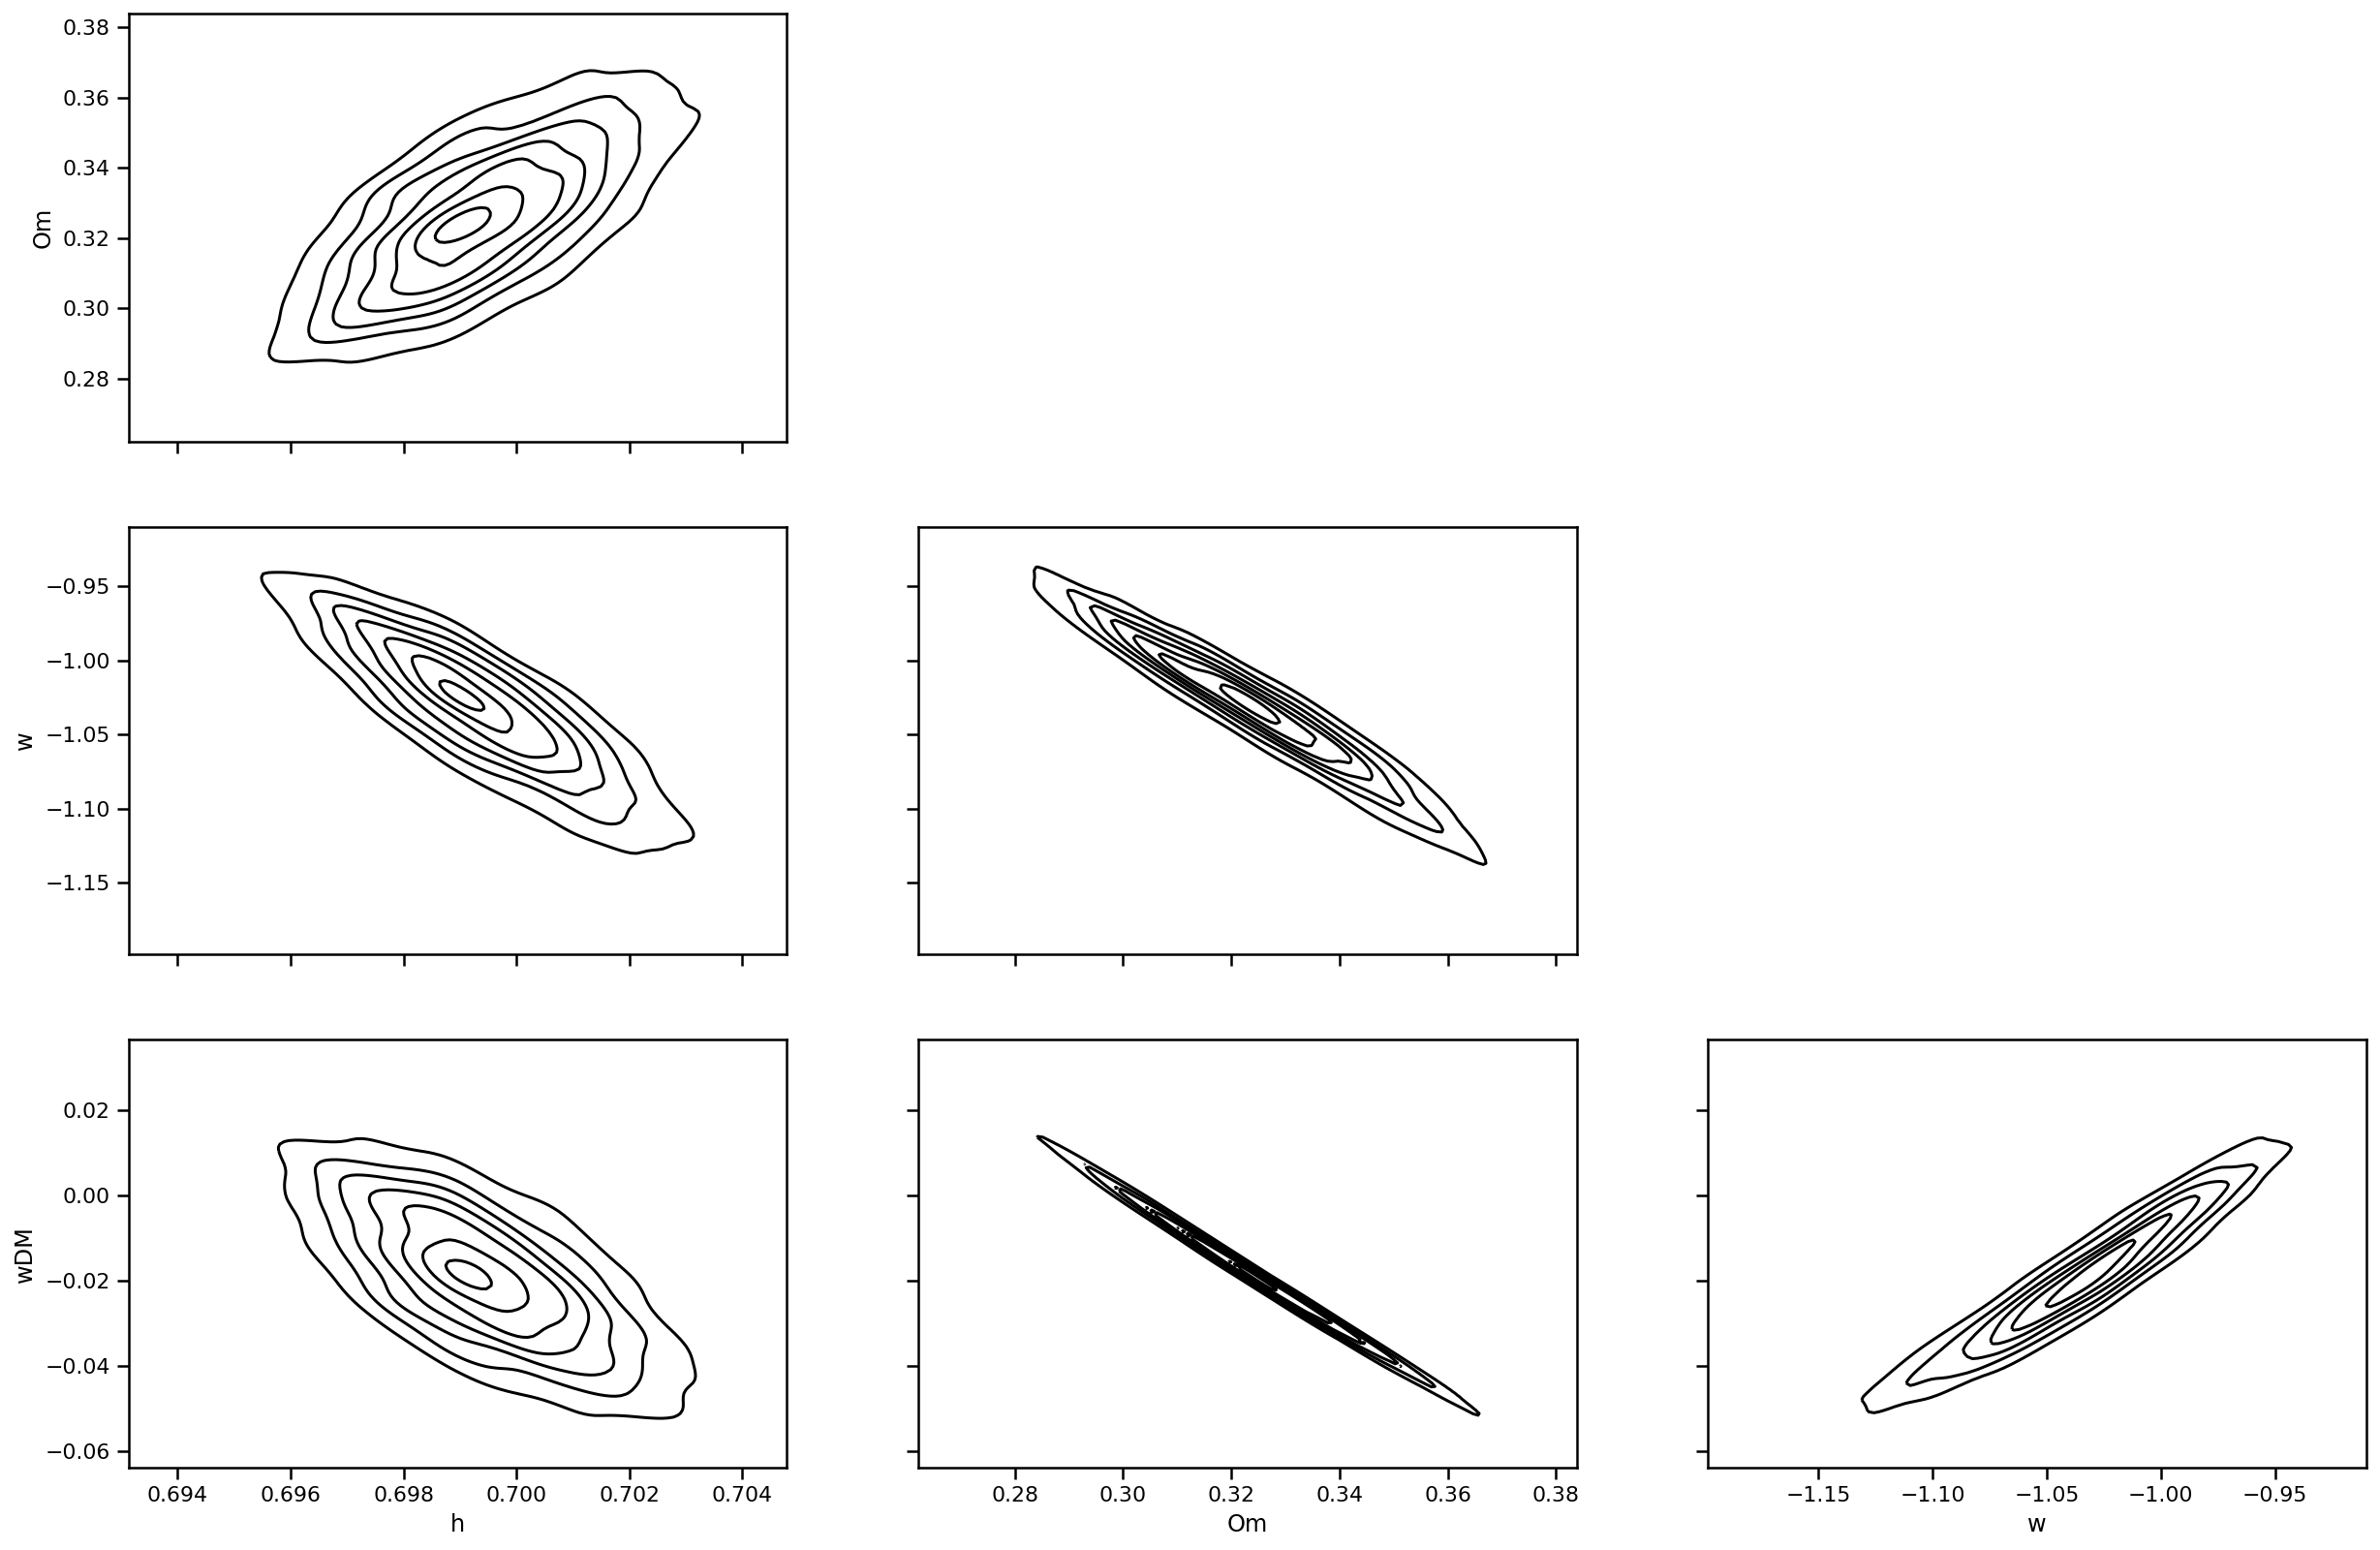

In [33]:
axes = az.plot_pair(trace, var_names=['h', 'Om', 'w', 'wDM'], kind=['kde'], divergences=True)